In [1]:
# This notebook takes the input dataset, finds quartiles for the medical interventions (IV in, max vaso in)
# for each block.
# We then discretise actions in the original dataset according to what bin they fall in, and then save 
# a new dataframe with the discretised actions.

In [2]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pandas import DataFrame

In [4]:
orig_data = pd.read_csv("../data/MIMICtable.csv")

In [5]:
orig_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS
0,1,3,7245486000,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6527.0,50.0,13617.0,520.0,-7090.0,3,1
1,2,3,7245500400,0,17639.826435,0,0,0,0,1,...,84.000000,0.0,0.0,6577.0,50.0,13982.0,365.0,-7405.0,7,2
2,3,3,7245514800,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6627.0,50.0,14262.0,280.0,-7635.0,5,2
3,4,3,7245529200,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6677.0,50.0,14602.0,340.0,-7925.0,5,1
4,5,3,7245543600,0,17639.826435,0,0,0,0,1,...,279.999989,0.0,0.0,6727.0,50.0,15142.0,540.0,-8415.0,5,2


In [6]:
# # Add an END state to each trajectory. This takes some time, so comment out if already done!
# orig_data['END'] = False
# new_df = pd.DataFrame(columns=orig_data.columns)
# new_idx = 0
# for i in orig_data.index:
#     if i == 0:
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx +=1
#         continue
#     if orig_data.loc[i, 'icustayid'] != orig_data.loc[i-1, 'icustayid']:
#         # new patient; add an end state to the new_df
#         new_df.loc[new_idx, orig_data.columns] = np.nan
#         new_df.loc[new_idx, 'icustayid'] = new_df.loc[new_idx-1, 'icustayid']
#         new_df.loc[new_idx, 'END'] = True
#         new_idx += 1
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx += 1
#     else:
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx += 1
#     if i % 1000 == 0:
#         print i

# orig_data = new_df

In [7]:
# orig_data.to_csv("../data/MKdataset07Feb17.csv", index=False)

In [8]:
# assume we're using input_4hourly and max_dose_vaso as the input params for now
interventions = orig_data[["max_dose_vaso", "input_4hourly"]]

In [9]:
interventions.head()

,max_dose_vaso,input_4hourly
0,0.0,50.0
1,0.0,50.0
2,0.0,50.0
3,0.0,50.0
4,0.0,50.0


In [10]:
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"] >0]
adjusted_iv = interventions["input_4hourly"][interventions["input_4hourly"]>0]

In [11]:
vaso_quartiles = adjusted_vaso.quantile([0.25,0.50,0.75])
iv_quartiles = adjusted_iv.quantile([0.25,0.5,0.75])

In [12]:
vq = np.array(vaso_quartiles)
vq

array([0.08, 0.2 , 0.45])

In [13]:
ivq = np.array(iv_quartiles)
ivq

array([ 48. , 150. , 499.5])

In [14]:
# so, for vasopressors:
# 0 = input_0
# 0 < vaso < 0.08 = input_1
# 0.08 <= vaso < .225 = input_2
# .225 <= vaso < .45 = input_3
# .45 <= input_4

In [15]:
# for iv:
# 0 = input_0
# 0 < vaso < 50 = input_1
# 50 <= vaso < .180.435 = input_2
# 180.435 <= vaso < 529.757 = input_3
# 529.757 <= input_4

In [16]:
import copy
discretised_int = copy.deepcopy(interventions)

In [17]:
discretised_int['vaso_input'] = discretised_int['max_dose_vaso']
discretised_int['vaso_input'][interventions['max_dose_vaso'] == 0.0] = 0
discretised_int['vaso_input'][(interventions['max_dose_vaso'] > 0.0) & (interventions['max_dose_vaso'] < vq[0])] = 1
discretised_int['vaso_input'][(interventions['max_dose_vaso'] >= vq[0]) & (interventions['max_dose_vaso'] < vq[1])] = 2
discretised_int['vaso_input'][(interventions['max_dose_vaso'] >= vq[1]) & (interventions['max_dose_vaso'] < vq[2])] = 3
a = interventions['max_dose_vaso'] >= vq[2]
discretised_int['vaso_input'][a] = 4

In [19]:
discretised_int['iv_input'] = discretised_int['input_4hourly']
discretised_int['iv_input'][interventions['input_4hourly'] == 0.0] = 0
discretised_int['iv_input'][(interventions['input_4hourly'] > 0.0) & (interventions['input_4hourly'] < ivq[0])] = 1
discretised_int['iv_input'][(interventions['input_4hourly'] >=  ivq[0]) & (interventions['input_4hourly'] <  ivq[1])] = 2
discretised_int['iv_input'][(interventions['input_4hourly'] >=  ivq[1]) & (interventions['input_4hourly'] < ivq[2])] = 3
discretised_int['iv_input'][(interventions['input_4hourly'] >=  ivq[2])] = 4

<AxesSubplot:ylabel='Frequency'>

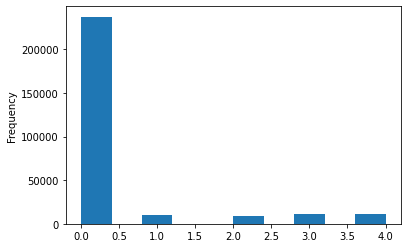

In [20]:
discretised_int['vaso_input'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

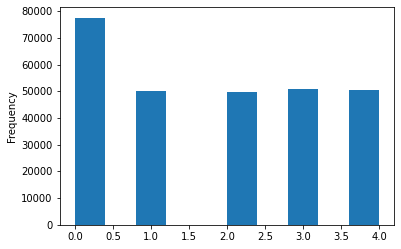

In [21]:
discretised_int['iv_input'].plot.hist()

In [22]:
disc_inp_data = copy.deepcopy(orig_data)

In [23]:
disc_inp_data['vaso_input'] = discretised_int['vaso_input']
disc_inp_data['iv_input'] = discretised_int['iv_input']

In [25]:
disc_inp_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,vaso_input,iv_input
0,1,3,7245486000,0,17639.826435,0,0,0,0,1,...,0.0,6527.0,50.0,13617.0,520.0,-7090.0,3,1,0.0,2.0
1,2,3,7245500400,0,17639.826435,0,0,0,0,1,...,0.0,6577.0,50.0,13982.0,365.0,-7405.0,7,2,0.0,2.0
2,3,3,7245514800,0,17639.826435,0,0,0,0,1,...,0.0,6627.0,50.0,14262.0,280.0,-7635.0,5,2,0.0,2.0
3,4,3,7245529200,0,17639.826435,0,0,0,0,1,...,0.0,6677.0,50.0,14602.0,340.0,-7925.0,5,1,0.0,2.0
4,5,3,7245543600,0,17639.826435,0,0,0,0,1,...,0.0,6727.0,50.0,15142.0,540.0,-8415.0,5,2,0.0,2.0


In [26]:
disc_inp_data['vaso_input'].value_counts()

0.0    237527
3.0     11603
4.0     10682
1.0     10093
2.0      8981
Name: vaso_input, dtype: int64

In [27]:
disc_inp_data['iv_input'].value_counts()

0.0    77522
3.0    50915
4.0    50349
1.0    50239
2.0    49861
Name: iv_input, dtype: int64

In [28]:
disc_inp_data.to_csv('../data/discretised_input_data.csv', index=False)